###Raveena Rai
###ed21s006###



##reference##

Neural Networks from Scratch in Python (book)
 
 by Harrison Kinsley, Daniel Kukieła

 https://python-course.eu/machine-learning/training-and-testing-with-mnist.php

##importing the required libraries##

In [ ]:
from copy import deepcopy
import numpy as np 
import matplotlib.pyplot as plt


from sklearn.model_selection import train_test_split
import tensorflow as tf
from sklearn.metrics import plot_confusion_matrix

Note: The notebook is made such that the cells can be run sequentially. 

## Template Classes

In [ ]:
class AutoDiffFunction():
    """Format for any function in general which has to be auto-differentiable
    """

    def __init__(self, *args, **kwds) -> None:
        self.saved_for_backward = {} # caching to save computation
        self.grad = {} # holds gradients

    def __call__(self, *args, **kwds):
        
        # performs one forward and backward pass in each call
        output = self.forward(*args, **kwds)
        self.grad = self.compute_grad(*args, **kwds)
        return output

    def forward(self, *args, **kwds):
        """Calculates a forward pass
        """
        pass

    def compute_grad(self, *args, **kwds):
        """Computes local gradient of that function itself w.r.t its input
        """
        pass

    def backward(self, *args, **kwds):
        """Computes actual gradient w.r.t. the loss after chained gradients ahead 
            of the function till the loss are passed 
        """
        pass


class Layer(AutoDiffFunction):
    """Format to create your own custom layer for the model
    """
    def __init__(self, *args, **kwds) -> None:
        super().__init__(*args, **kwds)

        self.weights = {} # holds weights of the layer
        self.optimizer = None # optimizer for the layer

    def initialize_weights(self, *args, **kwds):
        """Initialize weights for the layer
        """
        pass

    def update_weights(self):
        """Updates weights of the layer using layer's assigned optimizer
        """
        self.optimizer.step(self)


class Loss(AutoDiffFunction):
    """Format to create a custom loss function
    """

    def forward(self, y_true, y_pred):
        """Calculates a forward pass
        """
        pass 

    def backward(self):
        """Computes actual gradient w.r.t. the loss after chained gradients ahead 
            of the function till the loss are passed 
        """
        return self.grad["x"]

    def compute_grad(self, y_true, y_pred):
        """Computes local gradient of that function itself w.r.t its input
        """
        pass


class Optimizer():
    """Format to create a custom optimizer
    """
    def __init__(self, *args, **kwds):
        self.remember = {} # remembering parameters from last iteration
        pass

    def step(self, layer):
        """Performs the update step for weights of the optmizer

        Args:
            layer: Layer object assigned to the optimizer 
        """
        pass    

## Activation Functions

For this assignment we implement the following activation functions:

1. Sigmoid activation

$$y = \sigma(x) = \frac{1}{1 + e^{-x}}$$

$$\frac{dy}{dx} = \frac{-e^{-x}}{(1 + e^{-x})^2} = \sigma(x)(1 - \sigma(x))$$



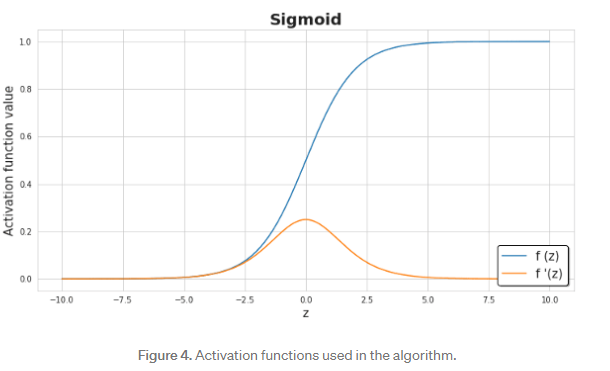



2. ReLU activation

$$y = ReLU(x) = max(0, x)$$

$$ \frac{dy}{dx} = \left\{
\begin{array}{ll}
      1 & x\geq 0\\
      0 & x\leq 0 \\
\end{array} 
\right.$$


$$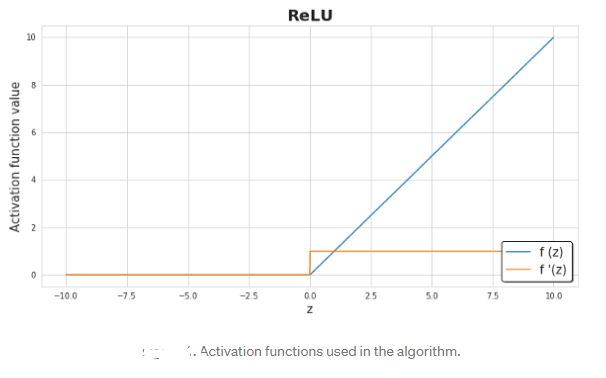

3. Tanh activation
$$y = tanh(x) = \frac{e^x - e^{-x}}{e^x + e^{-x}}$$
$$\frac{dy}{dx} = \frac{4}{(e^x + e^{-x})^2} = 1 - (tanh(x))^2$$


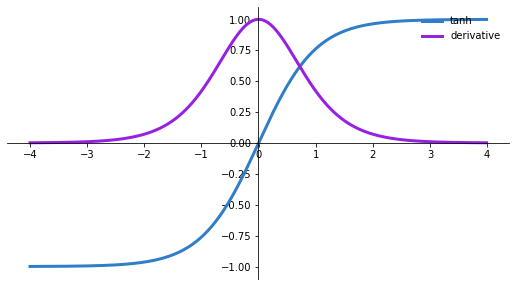

In [3]:
class Sigmoid(AutoDiffFunction):
    """ 
    Represents the Sigmoid Activation function
    """
    def __init__(self) -> None:
        super().__init__()

    def forward(self, x):
        self.saved_for_backward = 1/(1 + np.exp(-x))
        return self.saved_for_backward

    def compute_grad(self, x):
        y = self.saved_for_backward

        return {"x": y*(1-y)}

    def backward(self, dy):
        return dy * self.grad["x"]      


class RelU(AutoDiffFunction):
    """ 
    Represents the RelU Activation function
    """
    def __init__(self) -> None:
        super().__init__()

    def forward(self, x):
        self.saved_for_backward = np.where(x>0.0, 1.0, 0.0)

        return x * self.saved_for_backward

    def compute_grad(self, x):
        return {"x": self.saved_for_backward}

    def backward(self, dy):
        return dy * self.grad["x"]
    
class Tanh(AutoDiffFunction):
    """ 
    Represents the Tanh Activation function
    """
    def __init__(self) -> None:
        super().__init__()

    def forward(self, x):
        self.saved_for_backward = (np.exp(x) - np.exp(-x)) / (np.exp(x) + np.exp(-x))

        return self.saved_for_backward

    def compute_grad(self, x):
        y = self.saved_for_backward

        return {"x": 1 - y**2}

    def backward(self, dy):
        return dy * self.grad["x"]

## Layers

For this assignment, we only use fully connected OR Dense layers where each input neuron is connected to each output neuron, along with a bias unit. Below is a representation of a fully connected layer.



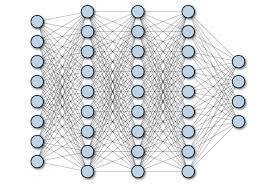



The equation for such a layer is simply

$$y = FullyConnected(x) = wx + b$$

$$\frac{dy}{dw} = x^T \quad\frac{dy}{dx} = w^T  \quad\frac{dy}{db} = 1$$

In [4]:
class FC(Layer):
    def __init__(self, in_dim, out_dim, weight_decay=None, init_method="random") -> None:
        super().__init__()
        self.weight_decay = weight_decay
        self.init_method = init_method
        self.initialize_weights(in_dim, out_dim)

    def initialize_weights(self, in_dim, out_dim):
        
        if self.init_method == "random":
            scaling_factor = 1/np.sqrt(in_dim)
            self.weights["w"] = np.random.randn(in_dim, out_dim) * scaling_factor
            self.weights["b"] = np.random.randn(1, out_dim) * scaling_factor
        elif self.init_method == "xavier":  #normal initialization xaviers also known as glorot inialization 
            lim = np.sqrt(6 / (in_dim + out_dim))
            self.weights["w"] = np.random.uniform(low=-lim, high=lim, size=(in_dim, out_dim))
            self.weights["b"] = np.random.uniform(low=-lim, high=lim, size=(1, out_dim))

    def compute_grad(self, x):
        
        gradients = {}

        # y = x * w + b        
        # we compute gradients wrt w and x 
        # gradient wrt b is not required explicitly since we know that it's value is 1
        gradients["w"] = self.saved_for_backward["x"].T
        gradients["x"] = self.weights["w"].T

        return gradients


    def forward(self, x):
        output = x @ self.weights["w"] + self.weights["b"]
        self.saved_for_backward["x"] = x
        
        return output

    def backward(self, dy):
        
        # calculating gradients wrt input to pass on to previous layer for backprop
        dx = dy @ self.grad["x"]
        
        # calculating gradients wrt weights
        dw = self.grad["w"] @ dy
        db = np.sum(dy, axis=0, keepdims=True)

        # accomodating for weight_decay / L2 regularization
        if self.weight_decay:
            dw = dw + 2 * self.weight_decay * self.weights["w"]
            db = db + 2 * self.weight_decay * self.weights["b"]

        self.absolute_gradients = {"w": dw, "b": db}

        return dx

    def update_weights(self):
        self.optimizer.step(self)

## Loss Functions

The loss function dictates how good the output of the neural network is. Since we use MNIST dataset, our job is classification and hence we use the Categorical CrossEntropy loss function.I have also created the Mean Squared Error loss function to check how it performs for a classification task for which it's not meant. 

#### 1) CrossEntropy Loss

$$L(p, y) = \Sigma_{i=1}^{N} \Sigma_{k=1}^{K} y_{ik} \log p_{ik}$$ 

where $$y_{ik} = \left\{
\begin{array}{ll}
      1 & x \in class-k\\
      0 & else \\
\end{array} 
\right.$$

$p_{ik} =$ probability that $i^{th}$ sample falls in $k^{th}$ class

In our implementation, the given loss function is applied along with the activation function for the last layer i.e. Softmax activation. It's formula is given by the following equation

$ f: [x_1, x_2, ... x_k] \rightarrow [p_1, p_2, ... p_k]$ such that $p_i = \frac{e^{x_i}}{\Sigma_{k=1}^{K} e^{x_i}}$

Now, to find the derivative of loss w.r.t input we have apply the chain rule. Let $p(x)$ represent the softmax activation and $L$ represent the loss. Then the expression turns out to be:

$$\frac{\partial L}{\partial x} = \frac{\partial L(p, y)}{\partial p} \frac{\partial p(x)}{\partial x} = p - y$$

#### 2) Mean Squared Loss OR L2 Loss

$$L(p, y) = \frac{1}{2b}\Sigma_{i=1}^{b} \Sigma_{k=1}^{K} (p_{ik} - y_{ik})^2$$

where $$y_{ik} = \left\{
\begin{array}{ll}
      1 & x \in class-k\\
      0 & else \\
\end{array} 
\right.$$

$p_{ik} =$ probability that $i^{th}$ sample falls in $k^{th}$ class

As above, the MSE loss is applied along with Softmax activation on the last layer. The combined derivative of MSE loss and softmax is given by:

$$\frac{\partial L}{\partial a_i^{(L)}} = \frac{\partial L(p, y)}{\partial p} \frac{\partial p(a_i^{(L)})}{\partial a_i^{(L)}} = \Sigma_{j=1}^{K} p_j(p_j - y_j)[\delta_{ij} - p_i]$$

where $$\delta_{ij} = \left\{
\begin{array}{ll}
      1 & i=j\\
      0 & else \\
\end{array} 
\right.$$

As can be seen from the expression, unlike for Cross Entropy loss the expression cannot be vectorised and individual components have to be separately calculated.

In [5]:
# 1. CROSSENTROPY LOSS
class CrossEntropyLossFromLogits(Loss):
    def __init__(self) -> None:
        super().__init__()
        self.n_classes = None

    @staticmethod
    def softmax(x):
        v = np.exp(x)
        return v / np.sum(v, axis=1, keepdims=True)

    def encode(self, y): 
        encoded_y = np.zeros(shape=(len(y), self.n_classes))

        for i in range(len(y)):
            encoded_y[i,y[i]] = 1

        return encoded_y

    def forward(self, y_pred, y_true):
         
        probabilities = self.softmax(y_pred)
        y_true_encoded = self.encode(y_true)

        loss_value = np.mean(np.sum(- y_true_encoded * np.log(probabilities), axis=1))

        self.saved_for_backward["probabilities"] = probabilities
        self.saved_for_backward["y_true"] = y_true_encoded

        return loss_value

    def compute_grad(self, y_pred, y_true):

        return {"x": self.saved_for_backward["probabilities"] - self.saved_for_backward["y_true"]}        


# 2. MEAN SQUARED LOSS
class MSELossFromLogits(Loss):
    def __init__(self) -> None:
        super().__init__()
        self.n_classes = None

    @staticmethod
    def softmax(x):
        v = np.exp(x)

        return v / np.sum(v, axis=1, keepdims=True)

    def encode(self, y): 
        encoded_y = np.zeros(shape=(len(y), self.n_classes))

        for i in range(len(y)):
            encoded_y[i,y[i]] = 1

        return encoded_y
    
    @staticmethod
    def indicator(i, j):
        ind = {True: 1, False: 0}
        return ind[i==j]

    def forward(self, y_pred, y_true):
         
        probabilities = self.softmax(y_pred)
        y_true_encoded = self.encode(y_true)

        loss_value = np.mean(np.sum((probabilities - y_true_encoded)**2, axis=1))
        ##
        #loss_value = np.mean(np.sum(- y_true_encoded * np.log(probabilities), axis=1))
        #M= y_true[0]

        ##
        self.saved_for_backward["probabilities"] = probabilities
        self.saved_for_backward["y_true"] = y_true_encoded

        return loss_value

    def compute_grad(self, y_pred, y_true):

        probs = self.saved_for_backward["probabilities"]
        labels = self.saved_for_backward["y_true"]
        grad = np.zeros(shape=(len(y_true), self.n_classes))
        
        for point_counter in range(len(y_true)):
            res = 0
            for i in range(self.n_classes):
                for j in range(self.n_classes):
                    
                    res = probs[point_counter, j] * (probs[point_counter, j] - labels[point_counter, j]) * (self.indicator(i,j) - probs[point_counter, i])
                
                grad[point_counter, i] = res
        
        return {"x": grad}

## Optimizers

Optimizers basically denote how to make use of the gradients achieved through backpropogation to update the weights of the model. Based on the question.


1) adam<br>


All the default parameter values are taken from keras optimizers.

In [6]:
# 1. ADAM OPTIMIZER
class Adam(Optimizer):
    def __init__(self, lr=0.01, beta_1=0.9, beta_2=0.999, epsilon=1e-7):
        super().__init__()
        self.lr = lr
        self.beta_1 = beta_1
        self.beta_2 = beta_2
        self.epsilon = epsilon
        self.t = 1
        
    def step(self, layer):
        
        #Initialise update history
        if self.remember == {}:
            for weight_name, weight in layer.weights.items():
                self.remember[weight_name] = {}
                self.remember[weight_name]["v"] = np.zeros_like(weight)
                self.remember[weight_name]["m"] = np.zeros_like(weight)
        
        #Adam update rule
        for weight_name, weight in layer.weights.items():
            
            #Update m_t and v_t
            self.remember[weight_name]["m"] = self.beta_1 * self.remember[weight_name]["m"] + \
                                                (1 -self.beta_1) * layer.absolute_gradients[weight_name]
            
            self.remember[weight_name]["v"] = self.beta_2 * self.remember[weight_name]["v"] + \
                                                (1 - self.beta_2) * (layer.absolute_gradients[weight_name]**2)
            
            #Bias correction
            m_hat = self.remember[weight_name]["m"]/(1 - self.beta_1 ** self.t)
            v_hat = self.remember[weight_name]["v"]/(1 - self.beta_2 ** self.t)
            
            #Update parameters
            layer.weights[weight_name] = layer.weights[weight_name] - (self.lr / (np.sqrt(v_hat + self.epsilon))) * m_hat
            
        self.t += 1

## Framework for the Neural Network

In [65]:
class NeuralNet():
    def __init__(self, layers) -> None:
        self.layers = layers
        
        self.history = []

    def __call__(self, *args, **kwds):
        return self.forward(*args, **kwds)

    def compile(self, loss, optimizer):
        self.loss = loss

        for layer in self.layers:
            if isinstance(layer, Layer):
                layer.optimizer = deepcopy(optimizer) # each layer has it's own optimizer

    def forward(self, x):
        """Performs forward pass for the entire network

        Args:
            x (np.ndarray): input array

        Returns:
            np.ndarray: output of the neural network
        """
        for layer in self.layers:
            x = layer(x)

        return x

    def backward(self):
        """Performs one backward pass for the entire network
            and saves the gradients

        Returns:
            np.ndarray: gradient of the 1st layer
        """

        gradient = self.loss.backward()
        for layer in reversed(self.layers):
            gradient = layer.backward(gradient)

        return gradient

    def update_weights(self):
        """Updates weights of all layers using the chosen optimizer 
            and saved gradients
        """

        for layer in reversed(self.layers):
            if isinstance(layer, Layer):
                layer.update_weights()

    @staticmethod
    def accuracy_score(y_pred, y_true):
        """Returns accuracy score

        Args:
            y_pred (np.ndarray): predicted labels (batch_size X n_classes)
            y_true (np.ndarray): true labels (batch_size X 1)

        Returns:
            [float]: accuracy in fraction
        """

        pred_labels = np.argmax(y_pred, axis=1)
        return np.sum(pred_labels == y_true) / len(y_true)

    @staticmethod
    def create_batches(X, y, batch_size=64):
        """Creates batches from given dataset of given size

        Args:
            X (np.ndarray): input features
            y (np.ndarray): labels
            batch_size (int, optional): batch size. Defaults to 32.

        Returns:
            list: batches of data as list of (x,y) tuples
        """
        batches = []

        for i in range(len(y) // batch_size):
            start_idx = batch_size * i
            end_idx = batch_size * (i + 1)

            batches.append([X[start_idx: end_idx], y[start_idx: end_idx]])

        # take care of the last batch which might have batch_size less than the specified one
        if len(y) % batch_size != 0:
            batches.append([X[end_idx:], y[end_idx:]])

        return batches

    def fit(self, X_train, y_train, X_val, y_val, batch_size=64, epochs=15):
        """Fits the model onto the given data

        Args:
            X_train (np.ndarray): train features
            y_train (np.ndarray): train labels
            X_val (np.ndarray): validation features
            y_val (np.ndarray): validation labels
            batch_size (int, optional): batch size. Defaults to 32.
            epochs (int, optional): number of epochs to train the model. Defaults to 10.
        """

        # calculate number of classes to pass to the loss function
        self.loss.n_classes = len(np.unique(y_train))

        train_batches = self.create_batches(X_train, y_train, batch_size=batch_size)
        val_batches = self.create_batches(X_val, y_val, batch_size=batch_size)

        num_train_batches = len(train_batches)
        num_val_batches = len(val_batches)

        for epoch in range(1, epochs+1):

            total_train_loss = 0
            total_train_accuracy = 0

            ## TRAINING ##
            for X, y in train_batches:

                preds = self(X)
                total_train_loss += self.loss(preds, y)
                total_train_accuracy += self.accuracy_score(preds, y)

                _ = self.backward()
                self.update_weights()

            train_loss_per_epoch = total_train_loss / num_train_batches
            train_accuracy = total_train_accuracy / num_train_batches

            total_val_loss = 0
            total_val_accuracy = 0

            ## VALIDATION ##
            for X_v, y_v in val_batches:
                val_preds = self(X_v)
                total_val_loss += self.loss(val_preds, y_v)
                total_val_accuracy += self.accuracy_score(val_preds, y_v)
            
            val_loss_per_epoch = total_val_loss / num_val_batches
            val_accuracy = total_val_accuracy / num_val_batches
            
            print(f"Epoch: {epoch} Train Loss: {train_loss_per_epoch} Train Accuracy: {train_accuracy} Val Loss: {val_loss_per_epoch} Val Accuracy: {val_accuracy}")

            self.history.append({"Epoch" : epoch, 
                                    "Train Loss": train_loss_per_epoch,
                                    "Train Accuracy": train_accuracy,
                                    "Val Loss": val_loss_per_epoch,
                                    "Val Accuracy": val_accuracy})


        print("\nModel trained successfully!")

    def evaluate(self, X_test, y_test):
        """Evaluates the model on a test dataset

        Args:
            X_test (np.ndarray): test features 
            y_test (np.ndarray): test labels
        """

        preds = self(X_test)
        test_loss = self.loss(preds, y_test)
        accuracy = self.accuracy_score(preds, y_test)

        print(f"Test loss: {test_loss} Test accuracy: {accuracy}")

# Testing the framework on  MNIST Dataset

In [9]:
mnist = tf.keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()
class_names = ['0', '1', '2', '3', '4',
                   '5', '6', '7', '8', '9']

train_images = train_images / 255.0
test_images = test_images / 255.0

print(f"Train samples: {train_images.shape[0]} Test samples: {test_images.shape[0]}")

11501568/11490434 [==============================] - 0s 0us/step
Train samples: 60000 Test samples: 10000


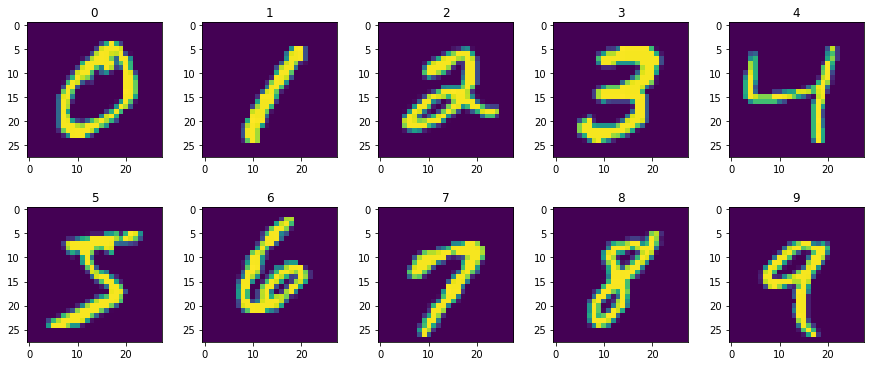

In [10]:
# Utility functions to preprocess image data and plotting

def flatten(arr):
    arr = arr.reshape(arr.shape[0], -1)
    return arr

class_names = ['0', '1', '2', '3', '4',
                   '5', '6', '7', '8', '9']

def plot_labels(data, labels, class_names, flatten=False):

    uniq_labels = np.unique(labels)

    fig, ax = plt.subplots(2,5, figsize=(15, 6))
    fig.subplots_adjust(wspace=0.3, hspace=0.3)
    ax = ax.reshape(-1)

    for i, label in enumerate(uniq_labels):

        img = data[np.where(labels == label)[0][0]]

        ax[i].set_title(class_names[label])
        
        if flatten:
            img = img.reshape(28, 28)

        ax[i].imshow(img)
    
    plt.show()

plot_labels(train_images, train_labels, class_names)

In [11]:
## Splitting the train labels itself into train and validation labels ##
train_images = flatten(train_images)
test_images = flatten(test_images)

train_images, val_images, train_labels, val_labels = train_test_split(train_images, train_labels, test_size=0.1, shuffle=True)
print(f"Train samples: {train_labels.shape[0]}, Validation samples: {val_labels.shape[0]}")

Train samples: 54000, Validation samples: 6000


In [69]:
## Creating an instance of the model with sigmoid ##
model = NeuralNet([FC(784,500), Sigmoid(), FC(500, 250),Sigmoid(), FC(250,100), Sigmoid(),FC(100,10)])
optimizer = Adam()
loss = CrossEntropyLossFromLogits()

## Compiling the model with the loss and optimizer chosen ##
model.compile(loss, optimizer)

## Training the model (TEST RUN) ##
model.fit(train_images, train_labels, val_images, val_labels, batch_size=64, epochs=15)

## Evaluating the model on test data ##
model.evaluate(test_images, test_labels)

#model.confusion_metrics()

Epoch: 1 Train Loss: 0.33140016699277913 Train Accuracy: 0.8987028534755135 Val Loss: 0.18695064156306695 Val Accuracy: 0.9464206560283689
Epoch: 2 Train Loss: 0.12089483305297405 Train Accuracy: 0.9645475414691943 Val Loss: 0.15199186374708648 Val Accuracy: 0.9576130319148937
Epoch: 3 Train Loss: 0.09269040573858187 Train Accuracy: 0.9727488151658767 Val Loss: 0.13142943700320336 Val Accuracy: 0.9615469858156029
Epoch: 4 Train Loss: 0.08140450446090433 Train Accuracy: 0.9754146919431279 Val Loss: 0.11609214285728102 Val Accuracy: 0.9689716312056738
Epoch: 5 Train Loss: 0.07415072125086339 Train Accuracy: 0.9775251777251185 Val Loss: 0.14400347750538503 Val Accuracy: 0.9586103723404256
Epoch: 6 Train Loss: 0.07223121145064787 Train Accuracy: 0.9780188586097945 Val Loss: 0.11955235792878864 Val Accuracy: 0.9659242021276596
Epoch: 7 Train Loss: 0.06669788808097371 Train Accuracy: 0.9790555884676145 Val Loss: 0.12519136575675374 Val Accuracy: 0.9671431737588652
Epoch: 8 Train Loss: 0.0666

In [ ]:
# plotting the metrics for the model#

def compare_models_plot(model):
    

    
    
    titles = ["Train Loss", "Train Accuracy", "Val Loss", "Val Accuracy"]
    
    fig, axs = plt.subplots(2,2, figsize=(10,10))
    axs = axs.reshape(-1)
    
    for i in range(4):
        
        title = titles[i]
        axs[i].set_title(title)
        
        
        axs[i].plot([d["Epoch"] for d in model.history], 
                            [d[title] for d in model.history], 
                            
                            )
            
        axs[i].legend()
        
    plt.show()

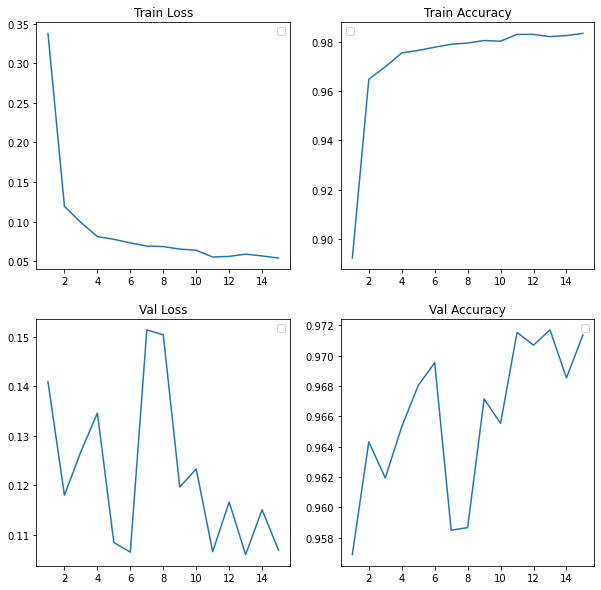

In [ ]:
compare_models_plot(model)

In [12]:
import sklearn
import pandas as pd

In [55]:

def get_confusion_matrix():

    

    mnist = tf.keras.datasets.mnist
    (train_images, train_labels), (test_images, test_labels) = mnist.load_data()
    class_names = ['0', '1', '2', '3', '4',
                    '5', '6', '7', '8', '9']

    train_images = flatten(train_images / 255.0)
    test_images = flatten(test_images / 255.0) 

    
    model = NeuralNet([FC(784,500), Sigmoid(), FC(500, 250),Sigmoid(), FC(250,100), Sigmoid(),FC(100,10)]) 
    optimizer = Adam()
    loss = CrossEntropyLossFromLogits()

## Compiling the model with the loss and optimizer chosen ##
    model.compile(loss, optimizer)
    model.fit(train_images, train_labels, test_images, test_labels, batch_size=64, epochs=15)
    
    preds = np.argmax(model(test_images), axis=1)
    y_pred.append(preds)

    cf_matrix = confusion_matrix(test_labels, preds)
    print(cf_matrix)
    plt.figure(figsize=(14,14))

    sns.heatmap(cf_matrix, annot=True,square='False',linewidths=0.7, cmap='mako', fmt='0.4g', cbar=False)
    plt.ylabel('actual label')
    plt.xlabel('predicted label')



In [18]:
from sklearn.metrics import confusion_matrix

Epoch: 1 Train Loss: 0.2969369800584719 Train Accuracy: 0.9123634061833689 Val Loss: 0.14895899001007407 Val Accuracy: 0.9561106687898089
Epoch: 2 Train Loss: 0.1313918587839437 Train Accuracy: 0.9613372867803838 Val Loss: 0.15769752387957003 Val Accuracy: 0.9564092356687898
Epoch: 3 Train Loss: 0.10301721707804633 Train Accuracy: 0.9699327025586354 Val Loss: 0.15561678154601913 Val Accuracy: 0.9582006369426752
Epoch: 4 Train Loss: 0.09233919151826028 Train Accuracy: 0.9722647921108742 Val Loss: 0.15209507603444444 Val Accuracy: 0.9585987261146497
Epoch: 5 Train Loss: 0.0829701459771237 Train Accuracy: 0.974613539445629 Val Loss: 0.12141204163918638 Val Accuracy: 0.9675557324840764
Epoch: 6 Train Loss: 0.0770229315233794 Train Accuracy: 0.9770122601279317 Val Loss: 0.1279233605857504 Val Accuracy: 0.9689490445859873
Epoch: 7 Train Loss: 0.07580064224983588 Train Accuracy: 0.9769956023454158 Val Loss: 0.14087376664693513 Val Accuracy: 0.9627786624203821
Epoch: 8 Train Loss: 0.0772285348

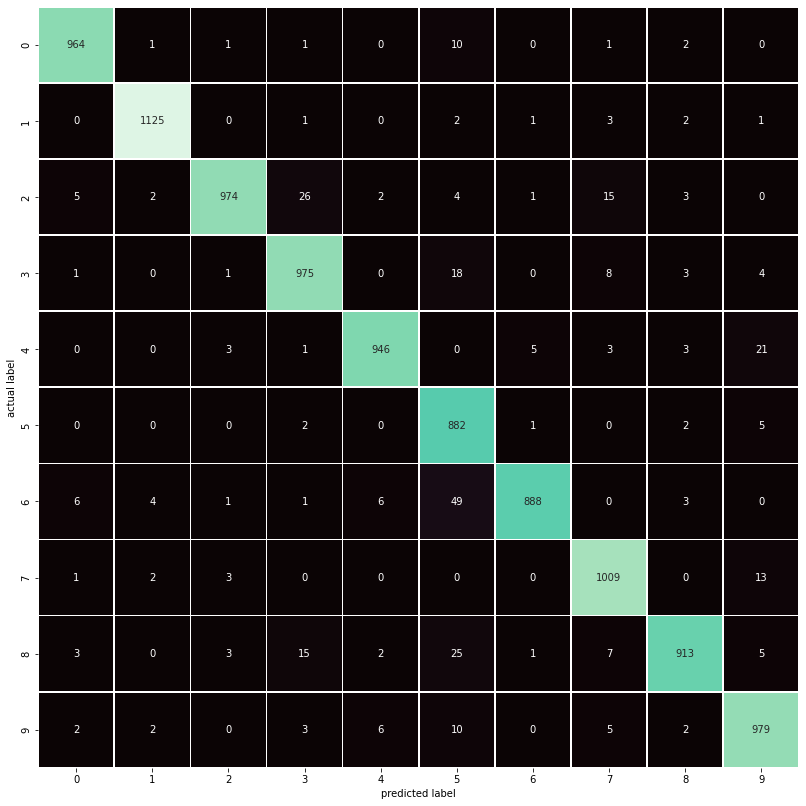

In [56]:
get_confusion_matrix()

##applying relu and tanh activation functions##

In [ ]:
## Creating an instance of the model with relu ##
model = NeuralNet([FC(784,500), RelU(), FC(500, 250),RelU(), FC(250,100), RelU(),FC(100,10)])
optimizer = Adam()
loss = CrossEntropyLossFromLogits()

## Compiling the model with the loss and optimizer chosen ##
model.compile(loss, optimizer)

## Training the model (TEST RUN) ##
model.fit(train_images, train_labels, val_images, val_labels, batch_size=64, epochs=15)

## Evaluating the model on test data ##
model.evaluate(test_images, test_labels)

Epoch: 1 Train Loss: 0.27486885351931145 Train Accuracy: 0.9212270438388626 Val Loss: 0.21136155982713414 Val Accuracy: 0.9426529255319149
Epoch: 2 Train Loss: 0.1692048485006074 Train Accuracy: 0.9561179403633491 Val Loss: 0.16615869015627835 Val Accuracy: 0.9545656028368795
Epoch: 3 Train Loss: 0.14889996583469228 Train Accuracy: 0.9623321484992101 Val Loss: 0.17084674947458708 Val Accuracy: 0.9563386524822695
Epoch: 4 Train Loss: 0.1258511450262284 Train Accuracy: 0.9695337184044234 Val Loss: 0.16452767364276671 Val Accuracy: 0.9657025709219859
Epoch: 5 Train Loss: 0.11383049581225085 Train Accuracy: 0.9726192239336493 Val Loss: 0.1494451302269553 Val Accuracy: 0.9672539893617021
Epoch: 6 Train Loss: 0.10856176309685915 Train Accuracy: 0.9738534261453397 Val Loss: 0.15520779525340503 Val Accuracy: 0.964982269503546
Epoch: 7 Train Loss: 0.11433864149982287 Train Accuracy: 0.9736868088467614 Val Loss: 0.1935598022838403 Val Accuracy: 0.9655363475177305
Epoch: 8 Train Loss: 0.103033452

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in multiply


Epoch: 11 Train Loss: nan Train Accuracy: 0.981166074249605 Val Loss: 0.17075607385822347 Val Accuracy: 0.9713541666666667
Epoch: 12 Train Loss: 0.08471059985952915 Train Accuracy: 0.9803391587677726 Val Loss: 0.15670581951397053 Val Accuracy: 0.9703568262411348
Epoch: 13 Train Loss: 0.08031505627011641 Train Accuracy: 0.9821842910742495 Val Loss: 0.21877955255222695 Val Accuracy: 0.9615469858156029
Epoch: 14 Train Loss: nan Train Accuracy: 0.9791111275671406 Val Loss: nan Val Accuracy: 0.9648160460992907
Epoch: 15 Train Loss: nan Train Accuracy: 0.9820608708530806 Val Loss: 0.18881383621334527 Val Accuracy: 0.9711879432624114

Model trained successfully!
Test loss: 0.176886282581403 Test accuracy: 0.9724


In [ ]:
# plotting the metrics for the model#

def compare_models_plot(model):
    

    
    
    titles = ["Train Loss", "Train Accuracy", "Val Loss", "Val Accuracy"]
    
    fig, axs = plt.subplots(2,2, figsize=(10,10))
    axs = axs.reshape(-1)
    
    for i in range(4):
        
        title = titles[i]
        axs[i].set_title(title)
        
        
        axs[i].plot([d["Epoch"] for d in model.history], 
                            [d[title] for d in model.history], 
                            
                            )
            
        axs[i].legend()
        
    plt.show()

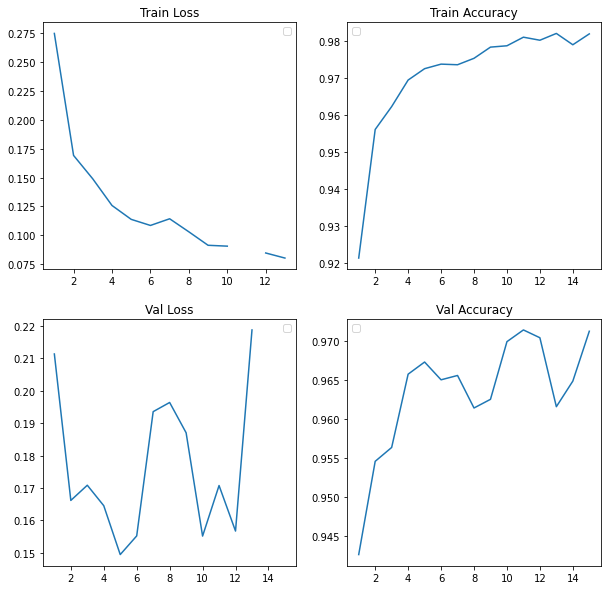

In [ ]:
compare_models_plot(model)

Epoch: 1 Train Loss: 0.303058096905806 Train Accuracy: 0.9156616471215352 Val Loss: 0.2739511450646171 Val Accuracy: 0.9379976114649682
Epoch: 2 Train Loss: 0.19292301176836335 Train Accuracy: 0.9508595415778252 Val Loss: 0.25373253800487783 Val Accuracy: 0.943968949044586
Epoch: 3 Train Loss: 0.1674945037322075 Train Accuracy: 0.9582389392324094 Val Loss: 0.18874213705660253 Val Accuracy: 0.9555135350318471
Epoch: 4 Train Loss: 0.14555950605078158 Train Accuracy: 0.9629197761194029 Val Loss: 0.16357950988406295 Val Accuracy: 0.9625796178343949
Epoch: 5 Train Loss: 0.1293089434908337 Train Accuracy: 0.9677671908315565 Val Loss: 0.21406005658323882 Val Accuracy: 0.9629777070063694
Epoch: 6 Train Loss: 0.11929742012616065 Train Accuracy: 0.9703158315565032 Val Loss: 0.17430978069151915 Val Accuracy: 0.9681528662420382


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in multiply


Epoch: 7 Train Loss: nan Train Accuracy: 0.9711320628997868 Val Loss: 0.20611489840603203 Val Accuracy: 0.9642714968152867
Epoch: 8 Train Loss: 0.09590706515712359 Train Accuracy: 0.9762126865671642 Val Loss: 0.18920671329104596 Val Accuracy: 0.9611863057324841
Epoch: 9 Train Loss: nan Train Accuracy: 0.9729644189765458 Val Loss: 0.2153296194571828 Val Accuracy: 0.9623805732484076
Epoch: 10 Train Loss: 0.10348545436942962 Train Accuracy: 0.9755130597014925 Val Loss: 0.1621290650019356 Val Accuracy: 0.9688495222929936
Epoch: 11 Train Loss: nan Train Accuracy: 0.9790778251599147 Val Loss: nan Val Accuracy: 0.9710390127388535
Epoch: 12 Train Loss: nan Train Accuracy: 0.9777951759061834 Val Loss: nan Val Accuracy: 0.9689490445859873
Epoch: 13 Train Loss: nan Train Accuracy: 0.980460421108742 Val Loss: nan Val Accuracy: 0.9690485668789809
Epoch: 14 Train Loss: nan Train Accuracy: 0.9794276385927505 Val Loss: nan Val Accuracy: 0.9645700636942676
Epoch: 15 Train Loss: nan Train Accuracy: 0.97

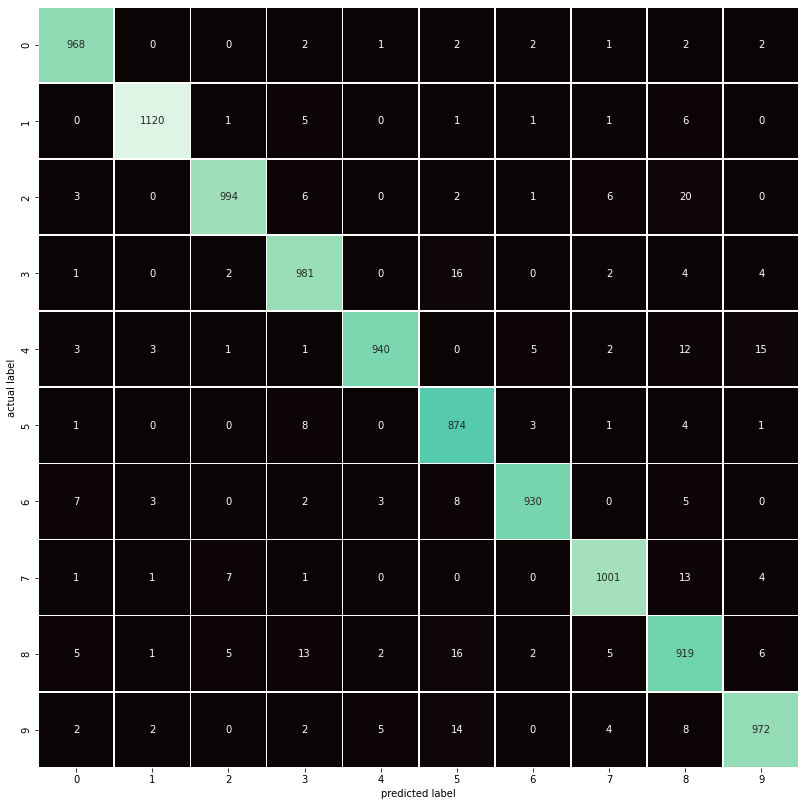

In [58]:

def get_confusion_matrix():

    

    mnist = tf.keras.datasets.mnist
    (train_images, train_labels), (test_images, test_labels) = mnist.load_data()
    class_names = ['0', '1', '2', '3', '4',
                    '5', '6', '7', '8', '9']

    train_images = flatten(train_images / 255.0)
    test_images = flatten(test_images / 255.0) 

    
    model = NeuralNet([FC(784,500), RelU(), FC(500, 250),RelU(), FC(250,100), RelU(),FC(100,10)])
    optimizer = Adam()
    loss = CrossEntropyLossFromLogits()

## Compiling the model with the loss and optimizer chosen ##
    model.compile(loss, optimizer)
    model.fit(train_images, train_labels, test_images, test_labels, batch_size=64, epochs=15)
    
    preds = np.argmax(model(test_images), axis=1)
    y_pred.append(preds)

    cf_matrix = confusion_matrix(test_labels, preds)
    print(cf_matrix)
    plt.figure(figsize=(14,14))

    sns.heatmap(cf_matrix, annot=True,square='False',linewidths=0.7, cmap='mako', fmt='0.4g', cbar=False)
    plt.ylabel('actual label')
    plt.xlabel('predicted label')

get_confusion_matrix()


In [ ]:
## Creating an instance of the model with tanh ##
model = NeuralNet([FC(784,500), Tanh(), FC(500, 250),Tanh(), FC(250,100), Tanh(),FC(100,10)])
optimizer = Adam()
loss = CrossEntropyLossFromLogits()

## Compiling the model with the loss and optimizer chosen ##
model.compile(loss, optimizer)

## Training the model (TEST RUN) ##
model.fit(train_images, train_labels, val_images, val_labels, batch_size=64, epochs=15)

## Evaluating the model on test data ##
model.evaluate(test_images, test_labels)

Epoch: 1 Train Loss: 0.3651935467313269 Train Accuracy: 0.8884774881516587 Val Loss: 0.3359748088824565 Val Accuracy: 0.9054188829787234
Epoch: 2 Train Loss: 0.37239287239692176 Train Accuracy: 0.8870026165086888 Val Loss: 0.3994222294883134 Val Accuracy: 0.8812056737588652
Epoch: 3 Train Loss: 0.42621370830182925 Train Accuracy: 0.8738089948657187 Val Loss: 0.4909939079299195 Val Accuracy: 0.8480718085106383
Epoch: 4 Train Loss: 0.4690739079720246 Train Accuracy: 0.8600784952606635 Val Loss: 0.43035722560898704 Val Accuracy: 0.8724512411347518
Epoch: 5 Train Loss: 0.4901586310272555 Train Accuracy: 0.8555798281990521 Val Loss: 0.4554793524819395 Val Accuracy: 0.8706227836879433
Epoch: 6 Train Loss: 0.5090225820175923 Train Accuracy: 0.8548701619273301 Val Loss: 0.49008766312994007 Val Accuracy: 0.8541112588652482
Epoch: 7 Train Loss: 0.5629220672822838 Train Accuracy: 0.8363324447077409 Val Loss: 0.6067620541437582 Val Accuracy: 0.8262411347517731
Epoch: 8 Train Loss: 0.57011091197684

In [ ]:
# plotting the metrics for the model#

def compare_models_plot(model):
    

    
    
    titles = ["Train Loss", "Train Accuracy", "Val Loss", "Val Accuracy"]
    
    fig, axs = plt.subplots(2,2, figsize=(10,10))
    axs = axs.reshape(-1)
    
    for i in range(4):
        
        title = titles[i]
        axs[i].set_title(title)
        
        
        axs[i].plot([d["Epoch"] for d in model.history], 
                            [d[title] for d in model.history], 
                            
                            )
            
        axs[i].legend()
        
    plt.show()

this is for tanh

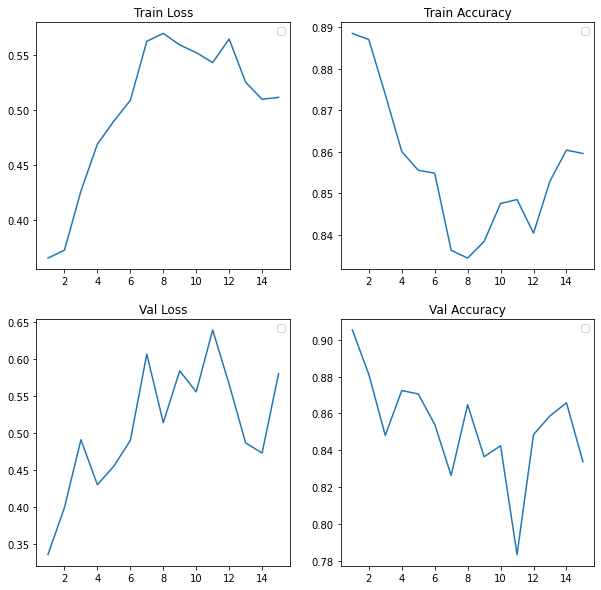

In [ ]:
compare_models_plot(model)

Epoch: 1 Train Loss: 0.3862617603985395 Train Accuracy: 0.8839285714285714 Val Loss: 0.3495173447726452 Val Accuracy: 0.9003781847133758
Epoch: 2 Train Loss: 0.3814045248294375 Train Accuracy: 0.886660447761194 Val Loss: 0.5282782969805039 Val Accuracy: 0.837281050955414
Epoch: 3 Train Loss: 0.4772853136249054 Train Accuracy: 0.8565764925373134 Val Loss: 0.5736255491311203 Val Accuracy: 0.8395700636942676
Epoch: 4 Train Loss: 0.5124507916134557 Train Accuracy: 0.8503631396588486 Val Loss: 0.6019949446448779 Val Accuracy: 0.8299164012738853
Epoch: 5 Train Loss: 0.5032811042371934 Train Accuracy: 0.8565265191897654 Val Loss: 0.6436992249825243 Val Accuracy: 0.7958797770700637
Epoch: 6 Train Loss: 0.5362439837901027 Train Accuracy: 0.8485974147121536 Val Loss: 0.5387303900317952 Val Accuracy: 0.8325039808917197
Epoch: 7 Train Loss: 0.5317082783334404 Train Accuracy: 0.8519456289978679 Val Loss: 0.5253553359453254 Val Accuracy: 0.8592754777070064
Epoch: 8 Train Loss: 0.5595480321592036 Tra

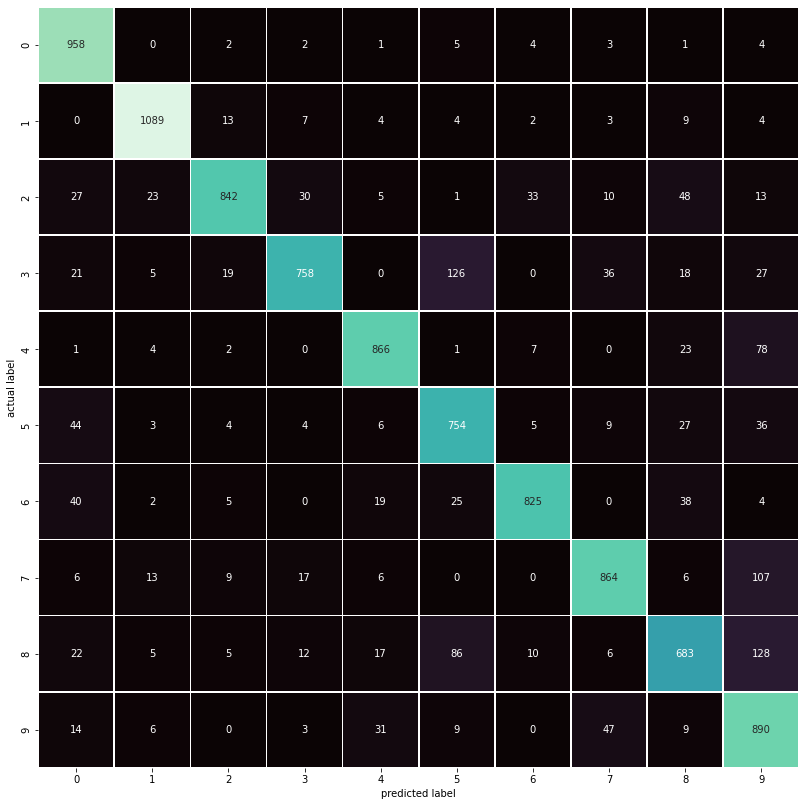

In [59]:

def get_confusion_matrix():

    

    mnist = tf.keras.datasets.mnist
    (train_images, train_labels), (test_images, test_labels) = mnist.load_data()
    class_names = ['0', '1', '2', '3', '4',
                    '5', '6', '7', '8', '9']

    train_images = flatten(train_images / 255.0)
    test_images = flatten(test_images / 255.0) 

    
    model = NeuralNet([FC(784,500), Tanh(), FC(500, 250),Tanh(), FC(250,100), Tanh(),FC(100,10)])
    optimizer = Adam()
    loss = CrossEntropyLossFromLogits()

## Compiling the model with the loss and optimizer chosen ##
    model.compile(loss, optimizer)
    model.fit(train_images, train_labels, test_images, test_labels, batch_size=64, epochs=15)
    
    preds = np.argmax(model(test_images), axis=1)
    y_pred.append(preds)

    cf_matrix = confusion_matrix(test_labels, preds)
    print(cf_matrix)
    plt.figure(figsize=(14,14))

    sns.heatmap(cf_matrix, annot=True,square='False',linewidths=0.7, cmap='mako', fmt='0.4g', cbar=False)
    plt.ylabel('actual label')
    plt.xlabel('predicted label')

get_confusion_matrix()


##L2 regularization##

##reference##
https://towardsdatascience.com/ridge-and-lasso-regression-a-complete-guide-with-python-scikit-learn-e20e34bcbf0b

In [ ]:
#L2 regularization using sk-learn library

from sklearn.linear_model import Ridge

rr = Ridge(alpha=0.1) 
# higher the alpha value, more restriction on the coefficients; low alpha > more generalization,
# in this case linear and ridge regression resembles
l2=rr.fit(train_images, train_labels)
Ridge_train_score = rr.score(train_images, train_labels)
Ridge_val_score = rr.score(val_images, val_labels)

In [ ]:
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import RepeatedKFold

In [ ]:
#rr.evaluate(test_images, test_labels)
Ridge_test_score = rr.score(test_images, test_labels) 

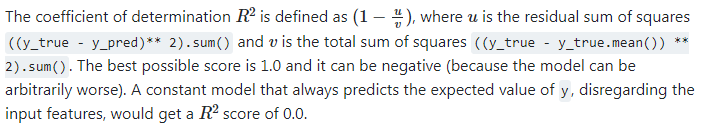

doesnt look like there is generalization error
also with huge change in alpha there is not much change( change in 3rd decimal) in the score
so l2 doesnt seems much required 

In [ ]:
print(Ridge_train_score,Ridge_val_score, Ridge_test_score)

0.6100257628093468 0.6134461051865066 0.6254017109286374


## Testing the framework on MNIST Dataset

In [71]:
# load mnist dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# scaling the images
x_train, x_test = x_train / 255.0, x_test / 255.0

# flatten images to vectors
x_train = flatten(x_train)
x_test = flatten(x_test)

print(f"Training samples: {len(x_train)} Test samples: {len(x_test)}")

Training samples: 60000 Test samples: 10000


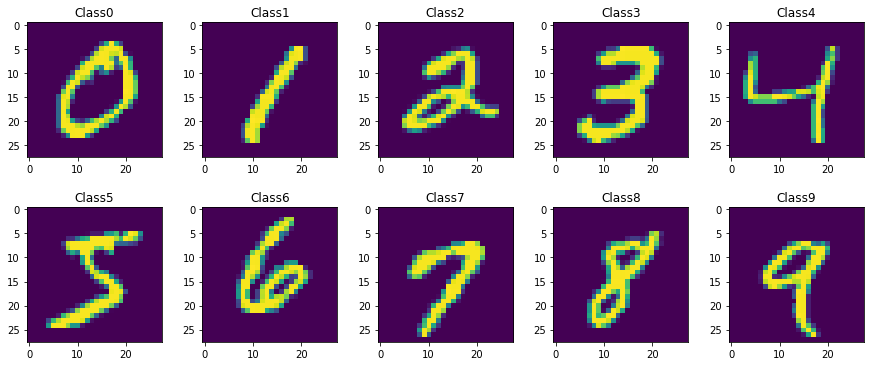

In [72]:
# plotting one image of each class
plot_labels(x_train, y_train, class_names=["Class"+str(i) for i in range(10)], flatten=True)

In [73]:
## 3 hyper-paramter configurations for MNIST ##

# Configuration 1

print("Configuration 1\n")
model1 = NeuralNet(([FC(784,128), RelU(), FC(128, 250),RelU(), FC(250,100), RelU(),FC(100,10)]))
model1.compile(loss=CrossEntropyLossFromLogits(), optimizer=Adam())
model1.fit(x_train, y_train, x_test, y_test, batch_size=128, epochs=15)

# Configuration 2

print("\nConfiguration 2\n")
model2 = NeuralNet(([FC(784,750), RelU(), FC(750, 128),RelU(), FC(128,100), RelU(),FC(100,10)]))
model2.compile(loss=CrossEntropyLossFromLogits(), optimizer=Adam())
model2.fit(x_train, y_train, x_test, y_test, batch_size=25, epochs=15)

# Configuration 3

print("\nConfiguration 3\n")
model3 = NeuralNet(([FC(784,500), RelU(), FC(500, 50),RelU(), FC(50,250), RelU(),FC(250,10)]))
model3.compile(loss=CrossEntropyLossFromLogits(), optimizer=Adam())
model3.fit(x_train, y_train, x_test, y_test, batch_size=64, epochs=15)

Configuration 1

Epoch: 1 Train Loss: 0.29865365621849244 Train Accuracy: 0.9106809701492538 Val Loss: 0.3760784860035648 Val Accuracy: 0.9119857594936709
Epoch: 2 Train Loss: 0.16560798595375706 Train Accuracy: 0.9536413912579957 Val Loss: 0.22248300735599966 Val Accuracy: 0.9316653481012658
Epoch: 3 Train Loss: 0.14091563702895807 Train Accuracy: 0.9618536780383795 Val Loss: 0.26747178589601955 Val Accuracy: 0.9230617088607594
Epoch: 4 Train Loss: 0.1079191941069244 Train Accuracy: 0.9691831023454158 Val Loss: 0.15765134342437231 Val Accuracy: 0.9646954113924051
Epoch: 5 Train Loss: 0.10831869091263165 Train Accuracy: 0.9700937277896232 Val Loss: 0.14994323475572632 Val Accuracy: 0.9660799050632911
Epoch: 6 Train Loss: 0.09712727725832919 Train Accuracy: 0.9738306236673774 Val Loss: 0.15603258259013186 Val Accuracy: 0.9634098101265823
Epoch: 7 Train Loss: 0.09913164247360017 Train Accuracy: 0.9735307835820896 Val Loss: 0.13191584681733814 Val Accuracy: 0.9722112341772152
Epoch: 8 Tra

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in multiply


Epoch: 4 Train Loss: nan Train Accuracy: 0.9547666666666849 Val Loss: 0.27182155807025316 Val Accuracy: 0.9494999999999982
Epoch: 5 Train Loss: nan Train Accuracy: 0.9621166666666838 Val Loss: 0.3225879708820659 Val Accuracy: 0.9378999999999986
Epoch: 6 Train Loss: nan Train Accuracy: 0.9630666666666831 Val Loss: 0.2104352997682238 Val Accuracy: 0.9580999999999981
Epoch: 7 Train Loss: 0.15258341047569898 Train Accuracy: 0.9663333333333496 Val Loss: 0.23430281643985829 Val Accuracy: 0.9519999999999981
Epoch: 8 Train Loss: nan Train Accuracy: 0.969350000000015 Val Loss: 0.1705271132569549 Val Accuracy: 0.9641999999999985
Epoch: 9 Train Loss: nan Train Accuracy: 0.9663500000000179 Val Loss: nan Val Accuracy: 0.9668999999999986
Epoch: 10 Train Loss: nan Train Accuracy: 0.9726000000000143 Val Loss: nan Val Accuracy: 0.9630999999999988
Epoch: 11 Train Loss: nan Train Accuracy: 0.9733666666666799 Val Loss: nan Val Accuracy: 0.9649999999999979
Epoch: 12 Train Loss: nan Train Accuracy: 0.970483

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in exp
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


Epoch: 13 Train Loss: nan Train Accuracy: 0.8352166666666713 Val Loss: nan Val Accuracy: 0.09799999999999943
Epoch: 14 Train Loss: nan Train Accuracy: 0.09871666666666783 Val Loss: nan Val Accuracy: 0.09799999999999943
Epoch: 15 Train Loss: nan Train Accuracy: 0.09871666666666783 Val Loss: nan Val Accuracy: 0.09799999999999943

Model trained successfully!

Configuration 3

Epoch: 1 Train Loss: 0.28783023649173445 Train Accuracy: 0.917860474413646 Val Loss: 0.2346046552494567 Val Accuracy: 0.940187101910828
Epoch: 2 Train Loss: 0.18156893513391337 Train Accuracy: 0.9533248933901919 Val Loss: 0.23572715079621187 Val Accuracy: 0.9414808917197452
Epoch: 3 Train Loss: 0.15192584603037265 Train Accuracy: 0.9618869936034116 Val Loss: 0.18300049845580374 Val Accuracy: 0.9578025477707006
Epoch: 4 Train Loss: 0.12707829682850008 Train Accuracy: 0.9684168443496801 Val Loss: 0.20672877512968335 Val Accuracy: 0.9475517515923567
Epoch: 5 Train Loss: 0.11690408584562795 Train Accuracy: 0.970665644989

In [74]:
# plotting the metrics for the model #

def compare_models_plot(models):
    
    n = len(models)
    model_names = ["model_" + str(i) for i in range(n)]
    
    colors = ["green", "blue", "red", "brown"]
    titles = ["Train Loss", "Train Accuracy", "Val Loss", "Val Accuracy"]
    
    fig, axs = plt.subplots(2,2, figsize=(10,10))
    axs = axs.reshape(-1)
    
    for i in range(4):
        
        title = titles[i]
        axs[i].set_title(title)
        
        for j in range(n):
            axs[i].plot([d["Epoch"] for d in models[j].history], 
                            [d[title] for d in models[j].history], 
                            c=colors[j], 
                            label=model_names[j])
            
        axs[i].legend()
        
    plt.show()

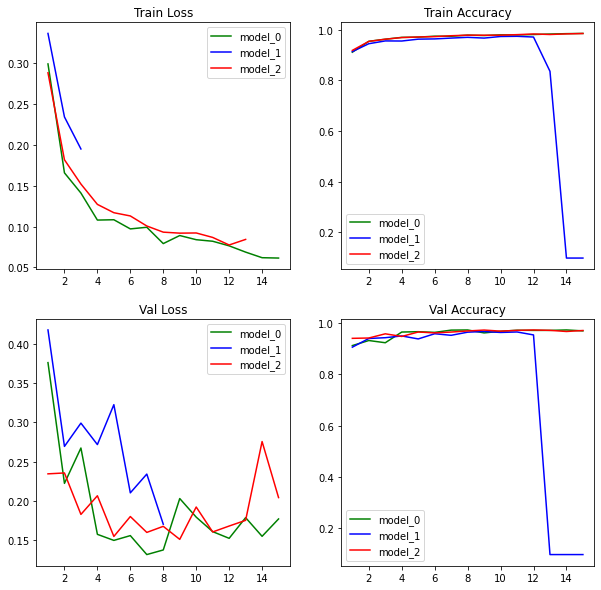

In [75]:
## Comparision of the configurations ##
compare_models_plot([model1, model2, model3])

<p style="text-align: center">THE END<p>